
 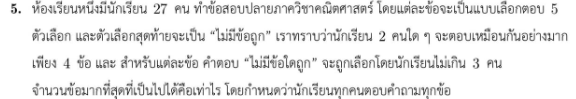






*  Click ***Runtime->run all*** to run the program
*   Edit the last cell to change the number of questions, number of students, and etc.

In [ ]:
# This problem can be solved using constraint programming.
# Approach: define the constraints and input them into the solver.
# The solver used here is Google OR-Tools..
# https://developers.google.com/optimization/introduction
# https://developers.google.com/optimization/cp
!pip install ortools
from ortools.sat.python import cp_model
import pandas as pd
from IPython.display import display, HTML



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.3/309.3 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.27.3 which is incompatible.
google-ai-generativelanguage 0.6.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.2

In [ ]:
# generate all unique pairs of students given a total number of students n.
# For example, generate_pairs(3) returns [(1, 2), (1, 3), (2, 3)].
def generate_pairs(n):
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((i+1, j+1))
    return pairs

# Create a dictionary mapping numbers to corresponding letters
# The last choice is always 'x', representing 'no answer - ไม่มีข้อถูก'.
# For example, create_mapping(5) returns {1:'a',2:'b',3:'c',4:'d',5:'x'}
def create_mapping(num_choices):
    mapping = {i: chr(96 + i) for i in range(1, num_choices)}
    mapping[num_choices]  = 'x'
    return mapping


In [ ]:
# This problem is similar to the employee_scheduling problem
# https://developers.google.com/optimization/scheduling/employee_scheduling

# num_q: Number of students
# num_s: Number of questions
# num_c: Number of choices per question
# max_x: Maximum number of students who can select 'x' per each question
# max_i: Maximum number of identical answer that any pair of students can select
def solve(num_q,num_s,num_c,max_x,max_i):

    all_students = range(1,num_s+1)
    all_questions = range(1,num_q+1)
    all_choices = range(1,num_c+1)
    all_pairs = generate_pairs(num_s)
    IntToLetterMapping = create_mapping(num_c)

    # Creates the model.
    model = cp_model.CpModel()

    # Initialize the variable
    # answers[(n, q, c)]: Represents whether student 'n' selects choice 'c' for question 'q'.
    # For example, if student #1 selects choices "a", "b", and "x" for the first three questions:
    # answers[(1, 1, 1)] = 1  # Student #1 selects choice "a" for question #1
    # answers[(1, 2, 2)] = 1  # Student #1 selects choice "b" for question #2
    # answers[(1, 3, 5)] = 1  # Student #1 selects choice "x" for question #3
    # Note: The mapping is IntToLetterMapping = {1: "a", 2: "b", 3: "c", 4: "d", 5: "x"}
    answers = {}
    # helper variable used to create non-linear constraint
    pairs = {}
    # Initialize the solution as an empty dictionary.
    # The 'solution' dictionary structure is as follows:
    # solution = {1: [], 2: [], 3: [], ...}
    # After solving, it will contain something like:
    # solution = {1: ['a', 'b', 'x', ...], 2: ['b', 'b', 'b', ...], ...}
    solution = {}
    for n in all_students:
        solution[n] = []


    # add variable to the model
    for n in all_students:
        for q in all_questions:
            for c in all_choices:
                answers[(n, q, c)] = model.new_bool_var(f"answers_n{n}_q{q}_c{c}")
    # Constraint 1 : Each student can select only one choice per question.
    for n in all_students:
        for q in all_questions:
            model.add_exactly_one(answers[(n, q, c)] for c in all_choices)
    # Constraint 2: Maximum number of students who can select 'X' per each
    # must not exceed 'max_x_per_questions'
    for q in all_questions:
      model.add(sum(answers[(n,q,num_c)] for n in all_students) <= max_x)
    # Constraint 3: Ensure that any pair of students does not have more than
    # 'max_identicals_between_pair' identical answers.
    # Note: This is a complex constraint. You may consider exploring alternative approaches,
    # as this implementation might not be the most optimized.
    for i,j in all_pairs:
        for q in all_questions:
            for c in all_choices:
                pairs[(i,j,q,c)] = model.new_bool_var(f"pairs_i{i}_j{j}_q{q}_c{c}")
                model.AddMultiplicationEquality(pairs[(i,j,q,c)], [answers[(i,q,c)], answers[(j,q,c)]])
    for i,j in all_pairs:
        model.add(sum(pairs[(i,j,q,c)] for q in all_questions for c in all_choices) <= max_i)


    # Creates the solver and solve.
    solver = cp_model.CpSolver()
    status = solver.solve(model)

    # If the solver finds a solution, save the results to the solution.
    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        for n in all_students:
            for q in all_questions:
                for c in all_choices:
                    if solver.value(answers[(n, q, c)]) == 1:
                      solution[n].append(IntToLetterMapping[c])
        return solution
    else:
        return []

    # Statistics.
    #print("\nStatistics")
    #print(f"  - conflicts: {solver.num_conflicts}")
    #print(f"  - branches : {solver.num_branches}")
    #print(f"  - wall time: {solver.wall_time}s")


In [ ]:
# This function takes the results generated by the 'solve' function and
# displays them in a formatted Pandas DataFrame with clear separation
# between rows for enhanced readability.
def print_solution(solution):
    if (solution):
        df = pd.DataFrame.from_dict(solution, orient='index')
        df.columns = [f'Q{i+1}' for i in range(df.shape[1])]
        styled_df = df.style.set_table_styles([{'selector': 'tr', 'props': [('border-bottom', '1px solid black')]}])
        display(styled_df)
    else:
        print ("No solution founds")

In [ ]:
############################# RUN THE CODE HERE ##########################
# Adjust the argument in the 'solve' function below as needed.

# num_q: Number of questions
# num_s: Number of students
# num_c: Number of choices per question
# max_x: Maximum number of students who can select 'no answer-X' per each question
# max_i: Maximum number of identical answer that any pair of students can select

# Note: For num_q = 0-17, the computation should complete in less than a minute.
# For higher values, the computation time may significantly increase.
# num_q = 19 may take more than half an hour
############################################################################

solution = solve(num_q=17,num_s=27,num_c=5,max_x=3,max_i=4)
print_solution(solution)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17
1,c,b,d,a,a,a,d,d,b,c,a,c,c,b,a,d,b
2,d,a,a,b,a,d,c,c,a,d,b,x,c,c,a,d,d
3,a,d,x,b,c,a,b,b,c,d,b,a,b,b,b,b,b
4,a,x,d,d,a,x,c,x,d,d,c,b,c,a,b,b,c
5,b,d,b,b,a,a,a,c,b,b,d,d,c,d,d,b,c
6,c,d,b,b,x,d,d,a,x,a,d,c,d,x,x,d,d
7,c,c,d,b,c,b,a,d,c,a,b,b,c,a,d,a,d
8,b,a,c,c,d,b,b,a,a,c,a,a,c,b,d,c,d
9,x,a,a,b,b,x,a,b,d,a,a,c,b,b,a,c,x
10,c,d,c,a,d,b,b,c,c,b,c,b,d,d,a,d,x
